In [1]:
import numpy as np
import matplotlib.pyplot as plt


SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
np.random.seed(123)
x = np.random.uniform(size=20)
samples = [1*(xx > 0.3) for xx in x]

# Bayes for lazy people: the beta-binomial model

Dinner time is arriving, and you, amidst the chaos of everyday life, have again forgotten to do groceries that day. In the fridge, a lonely trio: one egg, a bottle of (now still) week-old Coke, and a milk carton which might as well have always been there.

As your desperation piles up, your partner comes and asks the dreadful question: 

"What is there for dinner?"

You, always the improviser, throw your best poker face and respond. As you draw up your phone and open Google Maps, you assure them: "Hey baby, I thought of eating out today. What do you want to eat?". 

During the few seconds they take to ponder about your question, you type "good restaurants open now", filter for \$\$ restaurants, and check the top of the list


No AI model is necessary to predict what they will answer: "I don't know, anything's fine. What do you feel like eating?". 

And now it's your turn to use your best judgement to decide: out of the list below, which do you feel is better?

* George's Burgers: average score 5.0 out of 8 votes.
* Mr. Truffle's Sushi Bar: average score 4.8 out of 30 votes.
* Nonna Italiana: average score 4.6 out of 180 votes.

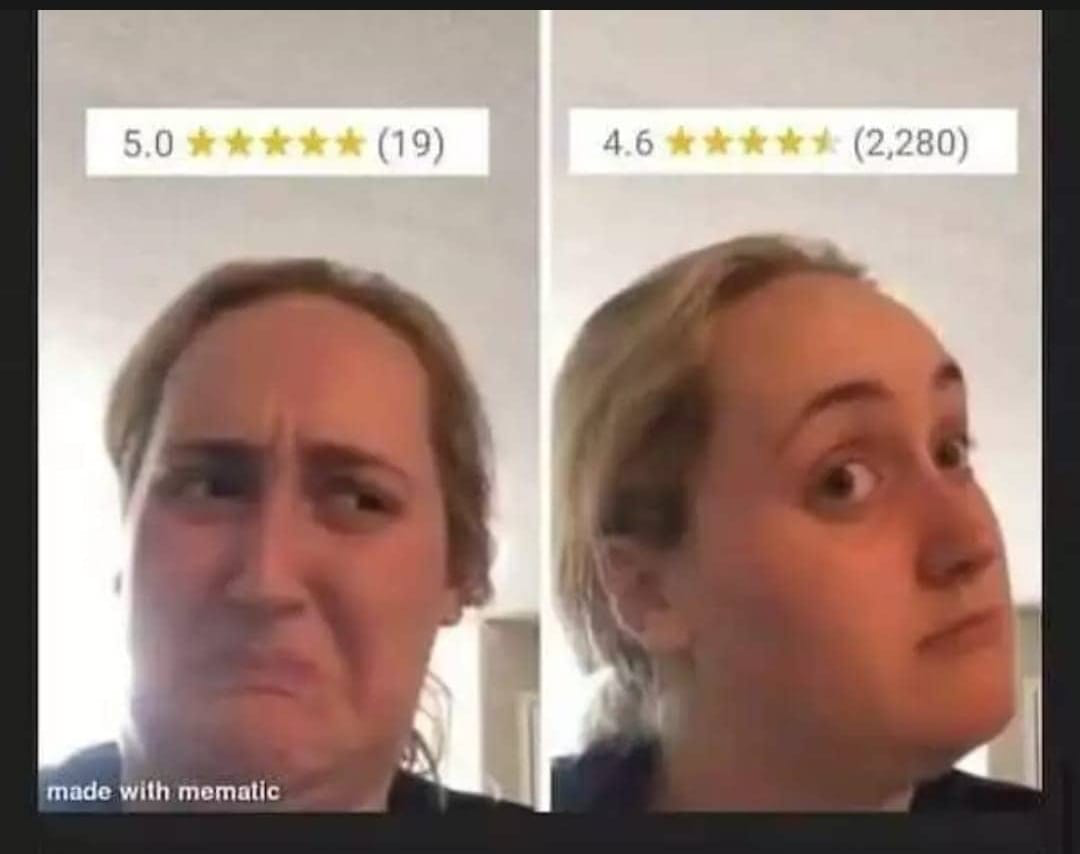

## Back to basics

Suppose we are given the following set of heads/tails data:

In [3]:
# list of 20 samples
n = 20
samples = [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1]

How likely is that the coin that genereted these observations is biased?

The most basic approach is to look at the mean of this list and "see" how far it is from 0.5:

In [4]:
## total of 1's in the whole list
print("Total observations:", np.sum(samples))

## mean 
print("Mean:", np.mean(samples))

Total observations: 15
Mean: 0.75


This looks pretty far from 0.5, but it's hard to know if it is too far.
> Maybe we just don't have enough data?

## A little bit of theory

In probability & statistics, the outcome of throwing a coin is called a **Bernoulli distribution**.

We define $p \in [0,1]$ as the probability of getting a 1, and $1-p$ as that of getting a 0. More formally:

$$X \sim \mathrm{Bernoulli}(p) \quad \Rightarrow \quad \mathbb P (X=k) = p^k (1-p)^{1-k}$$

What about throwing a coin $n$ times? 

Let $Y$ denote the number of successes of $n$ coin throws. That is, we throw a coin $n$ times and every time we get a 1 (a "success") we add it to our success counter.

Clearly $Y$ takes values in $\{0, 1, \ldots, n\}$, and can be written as

$$Y = \sum_{i=1}^n X_i$$

where each $X_i$ is an iid copy of the original Bernoulli $X$.

**Y is called a binomial variable**, denoted as $Y \sim \mathrm{Binom}(n,p)$. A binomial variable with parameter $p$ (same one as the Bernoulli case) has a probablity mass function given by
$$\mathbb P (Y=k) = \binom{n}{k} p^{k} (1-p)^{n-k}$$

(i.e. it counts all ways in which one can get $k$ successes out of $n$ trials)

Well then; how likely is it to get 15 (or more) successes out of 20 trials?

We can set $p=0.5$ as our null hypothesis; in other words, we assume that the coin is a $\mathrm{Binom}(n=20, p=1/2)$ variable, and see how likely our result is.

$$\begin{align}
\mathbb{P}(Y \geq 15) &= \sum_{k=15}^{20} \binom{20}{k} \frac{1}{2^k} \frac{1}{2^{n-k}}\\
&= \frac{1}{2^n}\sum_{k=15}^{20} \binom{20}{k}
\end{align}$$

In [5]:
from scipy.special import binom

# calculate probability masses for each value of k
axis_left, axis_right = range(0, 15), range(15, 21)
obs_left = (0.5)**20 * np.array([binom(20, k) for k in axis_left])
obs_right = (0.5)**20 * np.array([binom(20, k) for k in axis_right])

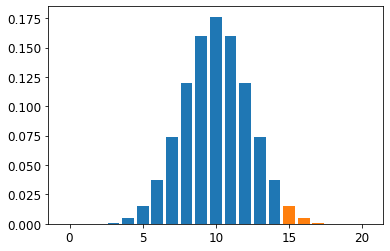

In [6]:
plt.bar(axis_left, obs_left)
plt.bar(axis_right, obs_right)
plt.show()

In [7]:
print("p-value = {0:.2f}".format(obs_right.sum()))

p-value = 0.02


So this p-value is about 2%. If we use 5% as a threshold, this means that we can reject the null hypothesis of an unbiased coint with $p = 0.5$

Obs: the higher $n$ were, the less likely $p=0.5$ would be if we saw 75% of points being successes. For example, if $n = 100$,

In [8]:
print("P(Y >= 0.75n) = {0:.7f}".format(
    (0.5)**100 * np.sum([binom(100, k) for k in range(75, 101)])
))

P(Y >= 0.75n) = 0.0000003


## What is the best estimate for $p$?

Our approach of "just divide the total successes by the amount of trials" (15/20 = 0.75) is, in one sense, the best estimate we have for $p$. 

This comes from **maximum likelihood estimation**.

Let's be explicit about which value of $p$ we are using, and write for a Bernoulli variable

$$\mathbb P (X = k; p) = p^k (1-p)^{1-k}$$

We have $n$ observations, or $n$ iid variables $X_i$. Each of them was observed to be either 0 or 1. Let $k_i \in \{0,1\}$ denote the observed value for $X_i$.

The **likelihood function** for the data we observed is the probability 

$$\begin{align}
L(p) &=  \mathbb P (X_1=k_1, X_2=k_2, \ldots, X_n = k_n; p) \\
&=\prod_{i=1}^n \mathbb P(X_i = k_i;p)\quad \mbox{by independence}\\
&= \prod_{i=1}^n p^{k_i} (1-p)^{1-k_i}
\end{align}$$

It is a common practice to take the log of the likelihood function, and write it as

$$\ell(p) = \log L(p) = \sum_{i=1}^n \left[ k_i \log p + (1-k_i) \log (1-p) \right]$$

We define the **maximum likelihood estimator** $p^*$ as the value of $p$ which maximizes the expression above. 

Since $\ell$ is differentiable, we can find $p^*$ from $\ell '(p^*) = 0$:

$$\begin{align}
\frac{d\ell}{dp} &= \frac{1}{p} \sum_{i=1}^n k_i - \frac{1}{1-p} \sum_{i=1}^n (1-k_i)\\
&= \frac{1}{p} \sum_{i=1}^n k_i - \frac{n}{1-p} + \frac{1}{1-p} \sum_{i=1}^n k_i\\
&= \left(\frac{1}{p} + \frac{1}{1-p} \right) \sum_{i=1}^n k_i - \frac{n}{1-p}\\
&= \frac{1}{1-p} \left[ \frac{1}{p} \sum_{i=1}^n k_i - n\right] \overset{!}{=}0
\end{align}
$$

From this it follows that 

$$p^* = \frac{1}{n} \sum_{i=1}^n k_i$$

which is 0.75 in our case. In other words, the mean observed success rate is the MLE estimator.

## What is the best estimate for $p$? (part II)

One answer lies in Bayesian statistics.


How much does our **belief** that $p=0.5$ increase/decrease every time we observe a success? Or a failure?

Recall that Bayesian inference is based on the concept of **belief update**: every time I observe something, my confidence that a parameter has a certain value goes up or down accordingly.

**Step 1**: promote our parameters to random variables, for instance

$$\mathbb P(X;p) \quad \mbox{now becomes} \quad \mathbb P(X|p)$$

where $p$ is now a random variable itself.

**Step 2**: choose a **prior distribution** for $p$, ie what distribution it follows.

For now, let's choose an **uninformative prior**: 

$$p \sim \mathrm{Uniform}([0,1])$$

ie. for all we know $p$ could be any value between 0 and 1.

**Step 3**: collect data (our 20 samples)

**Step 4**: review **Bayes' rule**:

$$\mathbb P(p|X) = \frac{\mathbb P(X|p) \mathbb P(p)}{Z}$$

where the partition function $Z$ is a normalization constant,

$$Z = \int_{[0,1]} \mathbb P(X|p) \mathbb P(p)\, dp$$


Bayes rule allows us to go from our **prior knowledge** ($\mathbb P(p)$) to our **posterior knowledge** ($\mathbb P(p|X)$) given our **likelihood** $\mathbb P(X|p)$.


For simplicity, let us see what happens to our distribution after observing **throwing the coin once and getting a success**, ie. $k_1 = 1$. 

We can use this procedure to **update our belief in $p$** based on the observation. Writing down all the parameters and distributions,

$$\begin{align}
p & \sim \mathrm{Unif}([0,1]) \quad \Rightarrow \mathbb P(p) = \mathbf{1}_{p \in [0,1]}\\
X_1|p & \sim \mathrm{Bernoulli}(p) \quad \Rightarrow \mathbb P (X_1|p) = p^{k_1}(1-p)^{1-k_1} = p
\end{align}$$

We can now procede to some long-ish calculations:

Numerator of Bayes' rule: 
$$\mathbb P(X_1|p) \mathbb P(p) = p \mathbf{1}_{p \in [0,1]}$$

Denominator of Bayes' rule = integral of numerator,

$$\int_0^1  p \mathbf{1}_{p \in [0,1]} dp = \frac 12, $$

so our posterior becomes 

$$\mathbb P(p|X_1) = 2p \mathbf{1}_{p \in [0,1]}$$

Now, we can repeat this procedure. Assume $X_2$ is measured to be $k_2 = 0$. This should make smaller values of $p$ more likely again. We can again write up our parameters:

$$\begin{align}
p & \quad\mbox{is such that} \quad \mathbb P(p) = 2p \mathbf{1}_{p \in [0,1]}\\
X_2|p & \sim \mathrm{Bernoulli}(p) \quad \Rightarrow \mathbb P (X_2|p) = p^{k_1}(1-p)^{1-k_1} = 1-p
\end{align}$$

So now:
* Numerator of Bayes rule:

  $$\mathbb P(X_2|p) \mathbb P(p) = 2p(1-p) \mathbf{1}_{p \in [0,1]}$$

* Denominator:
  $$\int_0^1  2p(1-p) \mathbf{1}_{p \in [0,1]} \, dp = \frac 13$$

So our new posterior distribution will be

$$\mathbb P(p|X1, X2) = 6 p (1-p)\mathbf{1}_{p\in [0,1]}$$

How do our distributions look like in each scenario?

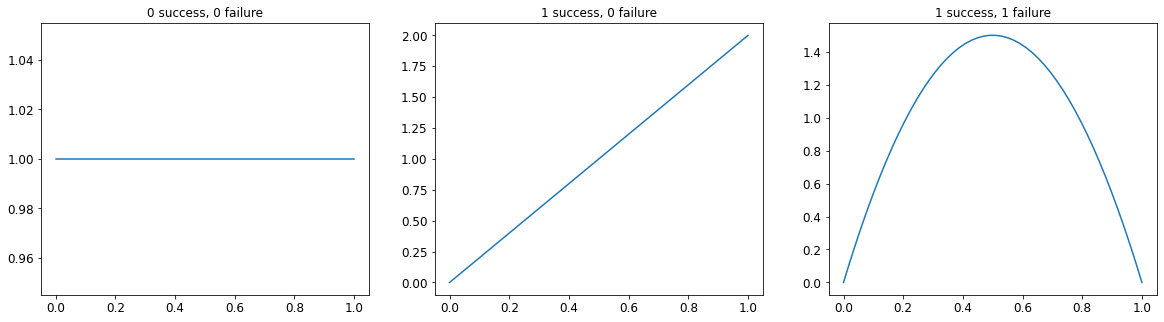

In [9]:
p = np.linspace(0,1)
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(p, np.ones_like(p))
ax[0].set_title("0 success, 0 failure")
ax[1].plot(p, 2*p)
ax[1].set_title("1 success, 0 failure")
ax[2].plot(p, 6*p*(1-p))
ax[2].set_title("1 success, 1 failure")
plt.show()

If you think about it thoroughly, you will realize that repeating this procedure over and over will always result in a PDF for $p$ **proportional to** 

$$\mathbb P(p|X_1, X_2,\ldots) \propto p^\mbox{some exponent} (1-p)^\mbox{some other exponent}$$

Furthermore, the $p$ exponent seems to grow by 1 every time there is a success, whereas the $(1-p)$ exponent seems to grow by 1 every time there is a failure. Can we make this more precise?

### Conjugate priors

Consider Bayes rule again:
    
$$\mathbb P(p|X) = \frac{\mathbb P(X|p) \mathbb P(p)}{Z}$$

If both the prior $\mathbb P(p)$ and the posterior $\mathbb P(p|X)$ are in the same family of distributions, then the prior and posterior are said to be **conjugate**, and the prior is called a **conjugate prior** to the likelihood $\mathbb P(X|p)$.


Since we have been going to and from distributions of the form $p^a (1-p)^b$, we might wonder that this is a conjugate prior. Prior to what? To a **binomial variable**.

___

[**Definition**] A variable $p$ is said to follows a **Beta distribution** with parameters $a, b > 0$ (denoted by $p \sim \mathrm{Beta}(a,b)$ ) if it has support on $[0,1]$ and PDF

$$\mathbb P(p) = \frac{p^{a-1} (1-p)^{b-1}}{B(a, b)}$$

where the normalization constant is the Beta function

$$B(a,b) = \int_0^1 p^{a-1} (1-p)^{b-1} \, dp = \frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)}$$

> The main use of Beta random variables is to model probabilities themselves!

Notice that all distributions we have dealt so far were actually examples of Beta variables:
* The uniform distribution $ \mathrm{Unif}([0,1])$ is actually $\mathrm{Beta}(1,1)$
* After one observation, we got $\mathbb P(p|X_1) = 2p$; this is the $\mathrm{Beta}(2,1)$ distribution
* Ater yet another observation, we got $\mathbb{P}(p|X_1,X_2) = 6p(1-p)$; this is the $\mathrm{Beta}(2,2)$ distribution

This suggests the following result (which is the core of what we want to discuss today):

[**Theorem**] Let $p \sim \mathrm{Beta}(a,b)$ be the prior distribution for a probability. Let $s \sim \mathrm{Binom}(n,p)$ be the amount of successes among $n$ iid Bernoulli trials. Also denote $f = n-s$ as the amount of failures 

Then, the posterior distribution of $p$ is

$$\boxed{p|f,s \sim \mathrm{Beta}(a+s, b+f)}$$

**This is the essence of the beta-binomial model**

Let's prove this. Letting 

$$\mathbb P(p; a,b) = \frac{p^{a-1} (1-p)^{b-1}}{B(a, b)}$$
$$ = \binom{s+f}{s} p^{s} (1-p)^f$$

we can calculate the numerator of Bayes' rule (ignoring constants):

$$\mathbb P(s|p) \mathbb P(p; a,b) \propto p^{a+s-1} (1-p)^{b+f-1}$$

This is formally identical to the expression for a $\mathrm{Beta}(a+s, b+f)$ variable. Indeed, normalizing yields a coefficient of $B(a+s, b+f)$ as wanted, finishing the proof.

### Applying this to our case
We have $s= 15$ successes and $f=5$ failures. If we assume the prior to be uniform (since we have no reason to believe otherwise *a priori*), then it is a $\mathrm{Beta}(1,1)$ distribution, thus making our posterior probability a $\mathrm{Beta}(16, 6)$ variable:

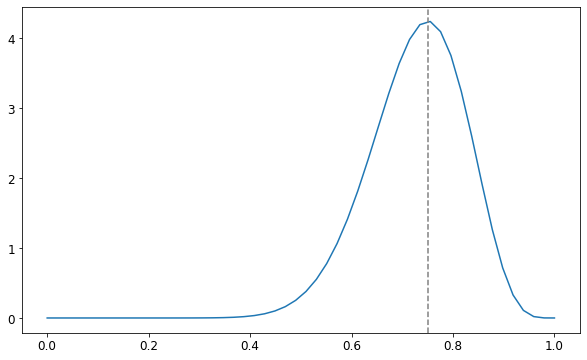

In [10]:
from scipy.stats import beta

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(p, beta.pdf(p, a=16, b=6))
ax.axvline(0.75, linestyle='--', color= 'gray'); plt.show()


The peak of this curve is called the **maximum a posteriori estimator**, or MAP. Notice how the curve is peaked at 0.75 (same value for the MLE estimate in the frequentist case), but also provides us with a confidence interval around it!

Three questions then are in order:
* Why is the MAP = MLE here?
* What about the mean?
* How to estimate confidence intervals?

**Why is the MLE estimator equal to the MAP here?**

Indeed, if we start with a $\mathrm{Beta}(1,1)$ variable, after $s$ successes and $n$ failures we find ourselves with a $\mathrm{Beta}(1+s, 1+f)$ variable, whose PDF is 

$$f(p) \propto p^{1+s-1} (1-p)^{1+f-1} = p^s (1-p)^f$$,

which attains its maximum at 

$$\boxed{p_* = \frac{s}{s+f}.}$$ 

This is the amount of 1's observed divided by the total number of observations. Hence, the MAP is equal to the MLE in the beta-binomial case, if we use a **uniform prior**.

**What about the expected value?**

Notice how we essentially studied the **mode** of the posterior. Had we chosen to look at the **mean** instead, we would have found

$$\boxed{\mathbb E[p] = \frac{s+1}{s+f+2}}$$

which in our case of $s=15$, $f=5$ yields 72.3%.

Interestingly, this expression is what we would have obtained by formally replacing $s \to s+1$ and $f \to f+1$ in the expression for the MAP!

This process has a name: **Laplace smoothing**. Since a $\mathrm{Beta}(a,b)$ variable has PDF proportional to $p^{a-1} (1-p)^{b-1}$, Laplace smoothing allows the power to *always* have at least one power of $p$ and $1-p$, making $f(p=0) = f(p=1) = 0$; in particular, even if we only have successes, we will still never set a probability of 0 of getting a 0. This was Laplace's correction when studying the question "is the Sun going to rise tomorrow?"

**How to estimate confidence intervals?**

Let $p_*$ be either the MAP or the mean, or even a median of the posterior distribution.

We want to find numbers $m, n$ satisfying $0\leq m \leq p_* \leq n\leq 1$ such that the interval $[m,n]$ contains a specific fraction of the probability mass.

Formally, if $F(x) \leq \mathbb P (p \leq x)$ is $p$'s CDF, then it must hold that 

$$F(n) - F(m) = 1 - \alpha$$

where $\alpha$ is some threshold (commonly $\alpha = 0.05$).

**There is no unique way to find $n$ and $m$**; in fact there are infinitely many options. 

*Simplest possible way*: use the analytic expression for the variance of a Beta variable and take symmetric intervals from the mode, ie. $[p_* - \sigma, p_* + \sigma]$:

$$X \sim \mathrm{Beta}(a, b) \quad \Rightarrow \quad \mathrm{Var}[X] = \frac{ab}{(a+b)^2 (a+b+1)}$$

In [11]:
# standard deviation; recall that our distribution is Beta(s+1, f+1)
s, f = 15, 5
std = np.sqrt((s+1)*(f+1)/((s+f+2)**2 * (s+f+3)))
print("[{0:.2f}, {1:.2f}]".format(s/(s+f) - std, s/(s+f) + std))

[0.66, 0.84]


One common (and arguiably optimal) option is the so-called **Highest (Posterior) Density Region**, or HDR. 

It is defined as follows. Let $f(p)$ be the PDF of our variable of interest. We want to find a value $f_*$ such that

$$1 - \alpha = \int_{f(p) \geq f_*} f(p)\; dp$$

The region $\{p: f(p) \geq f_*\}$ is our HDR credible interval.

We implemented a bisection-based method to find the endpoints of this interval. This can be easily done in the case of unimodal distributions. For our problem, the solution is as below:

In [12]:
def bisection(fun, lower=0, upper=1, tol=1e-6, maxiter=100, callback=None):
    """
    Bisection method to solve fun(x)=0,
    assuming root is between lower and upper.
    """
    if fun(lower)*fun(upper)>0:
        raise(ValueError('Bad initial lower and upper limits'))
    for iter in range(maxiter):
        x = (lower+upper)/2
        if fun(lower)*fun(x)>0:
            lower = x
        else:
            upper = x
        if np.abs(upper-lower)<tol:
            return (lower+upper)/2

In [13]:
from functools import partial

In [14]:
def hdr(pdf, cdf, mode, alpha=0.10, n_partitions=100):
    """Find hdr around mode for unimodal PDF"""
    f_max = pdf(mode)
    
    # iterate going further away from the mode
    for height in np.linspace(0, f_max, n_partitions, endpoint=False)[::-1]:
        
        # calculate end of interval
        a = bisection(lambda x: pdf(x)-height, lower=0, upper=mode-1e-6)
        b = bisection(lambda x: pdf(x)-height, lower=mode+1e-6, upper=1.0)
        
        # calculate mass contained between these points
        Fa, Fb = cdf(a), cdf(b)
        mass = Fb-Fa
        if mass >= 1-alpha:
            return a, b

In [15]:
alpha = 0.10  # we want to cover 1-alpha

a, b = hdr(pdf=partial(beta.pdf, a=s+1, b=f+1),
           cdf=partial(beta.cdf, a=s+1, b=f+1),
           mode=s/(s+f),
           alpha=alpha)

print("[a,b] = [{0:.2f}, {1:.2f}]".format(a,b))

[a,b] = [0.58, 0.88]


In [16]:
def plot_beta(s, f, ax, alpha=0.10):
    
    x = np.linspace(0,1, 100)
    a, b = hdr(pdf=partial(beta.pdf, a=s+1, b=f+1),
           cdf=partial(beta.cdf, a=s+1, b=f+1),
           mode=s/(s+f),
           alpha=alpha)


    ax.plot(x, beta.pdf(x, a=s+1, b=f+1)); ax.axvline(s/(s+f), color='black')
    ax.axvline(a, color='gray'); ax.axvline(b, color='gray'); ax.axhline(beta.pdf(a, s+1, f+1), linestyle='--')
    ax.fill_between(x, beta.pdf(x, a=s+1, b=f+1), where=(x >= a) & (x<=b), alpha=0.2)
    ax.legend(["PDF", "Mode ({0:.2f})".format(s/(s+f)), "Left ({0:.2f})".format(a), "Right ({0:.2f})".format(b)])
    ax.set_title(f"PDF of posterior and {round(100*(1-alpha))}% HDR")

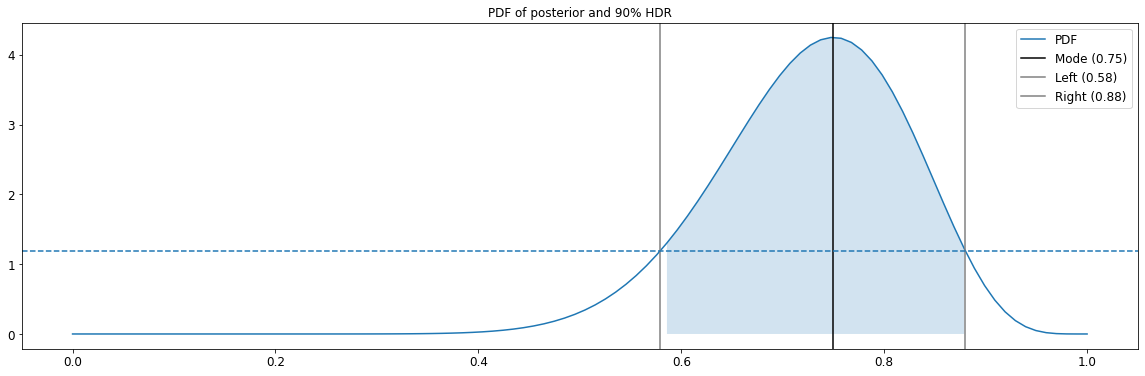

In [17]:
fig, ax = plt.subplots(figsize=(20,6))
plot_beta(s=15, f=5, ax=ax); plt.show()

In other words: we can be 90% sure that the real probability lies between 0.58 and 0.88. The coin is most likely biased upwards.

## Beyond coin throws: real-world examples

Consider two YouTube videos:
* Video A has 10 likes and 1 dislike
* Video B has 5000 likes and 500 dislikes

Both have 1 dislike for every 10 likes. If we consider these under the lense of the beta-binomial model, how much do we actually believe that both videos are equally good?

Again, with a uniform prior, 
* Video A follows a $\mathrm{Beta}(11, 2)$ distribution
* Video B follows a $\mathrm{Beta}(5001, 501)$ distribution

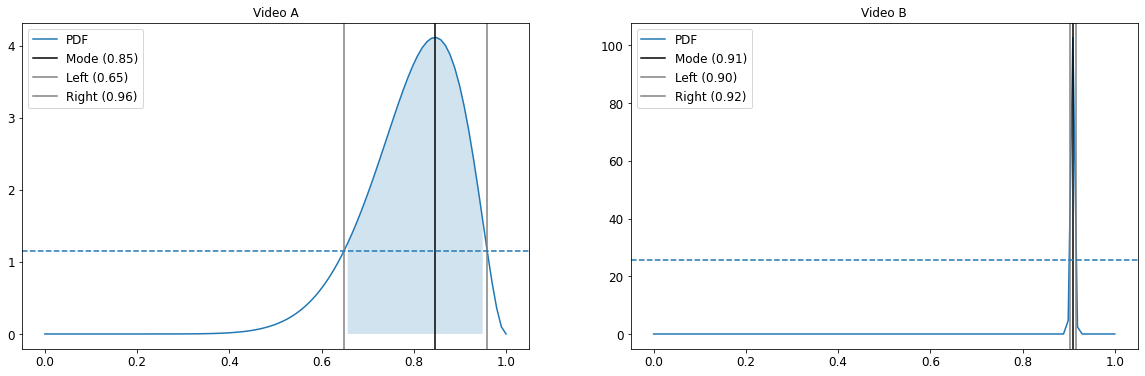

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(20,6))
plot_beta(s=11, f=2, ax=ax[0])
plot_beta(s=5001, f=501, ax=ax[1])
ax[0].set_title("Video A")
ax[1].set_title("Video B")
plt.show()

It is obvious here that video B is much more certain to have a high acceptance rate, around $0.91\pm0.01$. Video A, however, simply has less points: its acceptance rate could be anything from 0.65 up to 0.96. 

Of course, it might happen that video A is actually much better: there is a non-zero probability that it scores higher than the 0.91~0.92 of video B. But it is a much better bet to assume video B is better.

## And back to the restaurant example


* George's Burgers: average score 5.0 out of 8 votes.
* Mr. Truffle's Sushi Bar: average score 4.8 out of 30 votes.
* Nonna Italiana: average score 4.6 out of 180 votes.

To make things simpler, let's suppose a user can either enter a good (+1) or bad (+0) when analyzing a restaurant. 

Thus,
* George's Burgers had 8 successes and 0 failures.
* Mr. Truffle's Sushi Bar had approximately 29 successes and 1 failure
* Nonna Italiana had around 166 successes and 14 failures


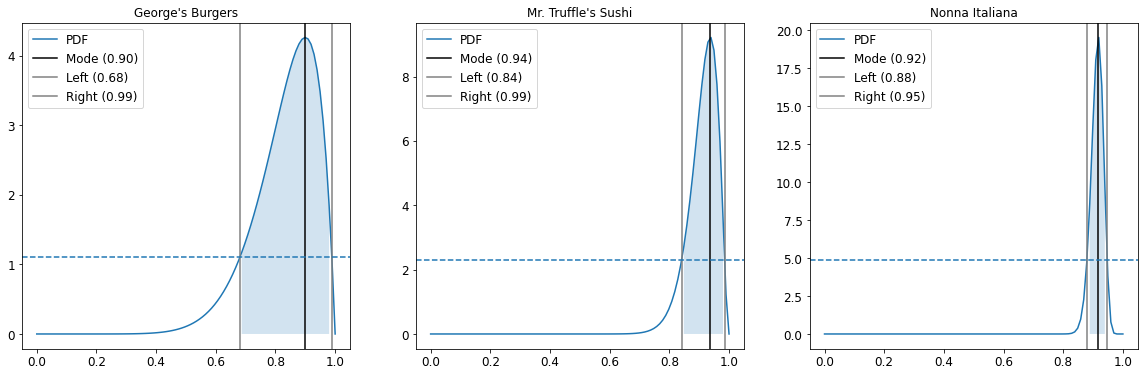

In [19]:
fig, ax = plt.subplots(ncols=3, figsize=(20,6))
plot_beta(s=8+1, f=0+1, ax=ax[0])
plot_beta(s=29+1, f=1+1, ax=ax[1])
plot_beta(s=166+1, f=14+1, ax=ax[2])
ax[0].set_title("George's Burgers")
ax[1].set_title("Mr. Truffle's Sushi")
ax[2].set_title("Nonna Italiana")
plt.show()

Interestingly enough, despite a "perfect score" on paper, George's Burgers suffers from not enough data: there is a significant chance that its actual hit rate is in the 70%s. There is a much lower chance of being wrong at Mr. Truffle's or Nonna, whose mode is high (92% and 94% respectively) and which are essentially bounded below in the mid-80%s. 

## References

Tutorial on beta-binomial models:
* http://varianceexplained.org/statistics/beta_distribution_and_baseball/

Credible intervals / HDR:
* https://stackoverflow.com/questions/22284502/highest-posterior-density-region-and-central-credible-region
* https://www.jstor.org/stable/2684423

